### Import Packages

In [1]:
# geospatial analysis
import geopandas as gpd
import shapely

# working with files
import os

# data analysis
import pandas as pd
import numpy as np
import scipy.stats as stats
from collections import defaultdict

# working with time
import calendar

# tracking optimization instances
import wandb

# web scraping
import requests
from bs4 import BeautifulSoup
import time
import re

# import helpful functions
from plotting_utils import *
from Model_PSCC_Draft_RC import *

### Read in Data

In [2]:
# prices data
huc8_ca_prices = gpd.read_file("Data/Prices/huc8_prices.geojson")
data_center_cost = 6e5 # ($/MW-year of capacity)


# ============ WATER SCARCITY AND EMISSIONS FOOTPRINT ============
footprint_df = pd.read_csv("Data/Footprint/footprint_per_MW.csv", index_col=0)
footprint_df['HUC8_str'] = footprint_df['HUC8'].map(lambda x: ''.join(['0']*(8-len(str(x)))) + str(x))


# ============ SOLAR AND WIND PRODUCTION PROPORTION ============
solar_proportion_df = pd.read_csv("Data/Solar/solar_proportion_2013_huc8.csv", index_col=0)
wind_proportion_df = pd.read_csv("Data/Wind/wind_proportion_2013_huc8.csv", index_col=0)


# ============ DEMAND PROFILES ============
# import only the 2GWh cases, because we only need the 2GWh cases.
flat_demand_2GWh = pd.read_csv("Data/Demand Profiles/flat_2_GWh.csv", index_col=0)
business_demand_2GWh = pd.read_csv("Data/Demand Profiles/business_2GWh.csv", index_col=0)
caiso_2013_2GWh = pd.read_csv("Data/Demand Profiles/caiso_2013_2GWh.csv", index_col=0)

In [3]:
# all data
huc8_df = huc8_ca_prices.merge(footprint_df, left_on="HUC8", right_on="HUC8_str")

# rename redundant columns
huc8_df.rename(columns={'HUC8_x': 'HUC8'}, inplace=True)
huc8_df.drop(columns=['HUC8_y'], inplace=True)

### Visualize Input Data

#### Time series

Text(0.5, 1.0, 'Demand Profile: Flat Demand Scenario')

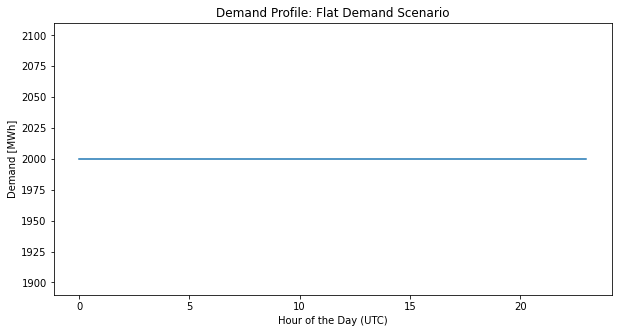

In [8]:
# flat demand curve (same every day)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(24), flat_demand_2GWh['0'].to_numpy()[0:24])

ax.set_xlabel("Hour of the Day (UTC)")
ax.set_ylabel("Demand [MWh]")
ax.set_title("Demand Profile: Flat Demand Scenario")

Text(0.5, 1.0, 'Demand Profile: Business-Heavy Scenario')

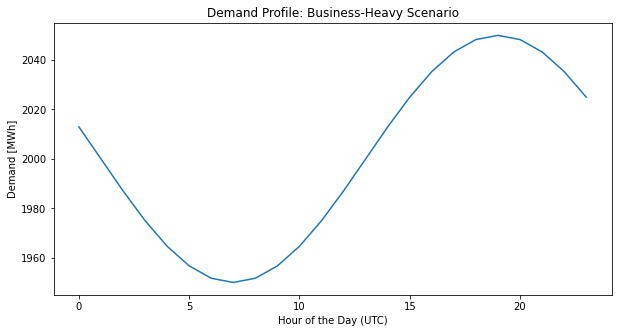

In [9]:
# business hour curve, inspired by https://www.ethree.com/wp-content/uploads/2024/07/E3-White-Paper-2024-Load-Growth-Is-Here-to-Stay-but-Are-Data-Centers-2.pdf page 14
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(24), business_demand_2GWh['0'].to_numpy()[0:24])

ax.set_xlabel("Hour of the Day (UTC)")
ax.set_ylabel("Demand [MWh]")
ax.set_title("Demand Profile: Business-Heavy Scenario")

In [10]:
# CAISO curve
caiso_2013_2GWh_np = caiso_2013_2GWh['0'].to_numpy().reshape((-1,24)) # reshape to 365 * 24

# compute mean and standard deviation
caiso_2013_mean = np.mean(caiso_2013_2GWh_np, axis=0)

caiso_2013_std = np.std(caiso_2013_2GWh_np, axis=0)


Text(0.5, 1.0, 'Demand Profile: CAISO Scenario')

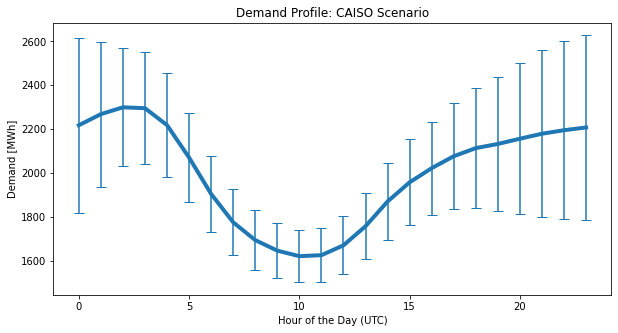

In [11]:
# plot CAISO curve
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(24), caiso_2013_mean, linewidth=4)
ax.errorbar(np.arange(24), caiso_2013_mean, yerr=caiso_2013_std, capsize=5, fmt='None')

ax.set_xlabel("Hour of the Day (UTC)")
ax.set_ylabel("Demand [MWh]")
ax.set_title("Demand Profile: CAISO Scenario")

#### Maps

<Axes: title={'center': 'Electricity Rate'}>

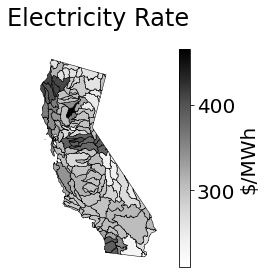

In [12]:
# grid electricity prices
visualize_stats(huc8_df, 'Electricity Price [$/MWh]', 'Electricity Rate', 'Grays', '$/MWh')

<Axes: title={'center': 'Solar LCOE'}>

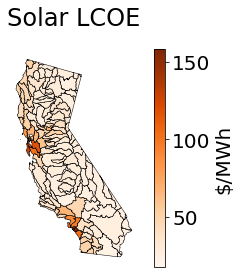

In [79]:
# solar electricity prices
visualize_stats(huc8_df, 'Mean Solar LCOE [$/MWh]', 'Solar LCOE', 'Oranges', '$/MWh')

<Axes: title={'center': 'Wind LCOE'}>

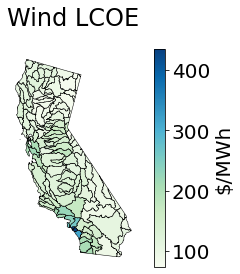

In [80]:
# wind electricity prices
visualize_stats(huc8_df, 'Mean Wind LCOE [$/MWh]', 'Wind LCOE', 'GnBu', '$/MWh')

<Axes: title={'center': 'Characterization factor'}>

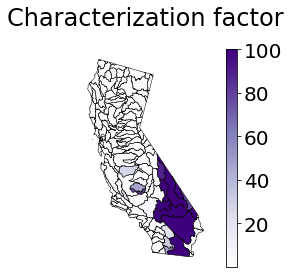

In [81]:
# chracterization factor (ratio of water scarcity footprint/water footprint)
visualize_stats(huc8_df, 'Characterization factor', 'Characterization factor', 'Purples', '') # a unitless measure.

<Axes: title={'center': 'Water Scarcity Footprint \nfor Grid Electricity'}>

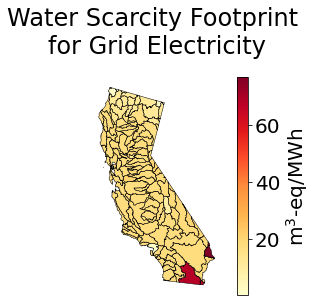

In [82]:
# water scarcity footprint: grid
visualize_stats(huc8_df, 'Grid Water Scarcity Footprint [m3-eq/MWh]', 'Water Scarcity Footprint \nfor Grid Electricity', 'YlOrRd', r'm$^3$-eq/MWh')

<Axes: title={'center': 'Water Scarcity Footprint \nfor Data Centers'}>

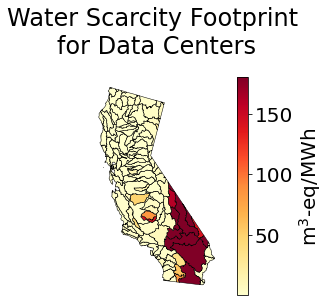

In [83]:
# water scarcity footprint: data center
visualize_stats(huc8_df, 'Data Center Water Scarcity Footprint [m3-eq/MWh]', 'Water Scarcity Footprint \nfor Data Centers', 'YlOrRd', r'm$^3$-eq/MWh')

<Axes: title={'center': 'Emissions Footprint \nof Grid Electricity'}>

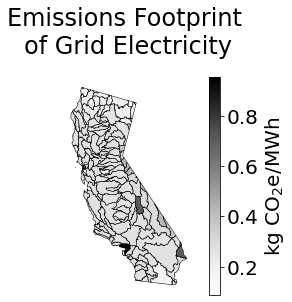

In [84]:
# emissions footprint: grid
visualize_stats(huc8_df, 'Grid Carbon Footprint [tons CO2-eq/MWh]', 'Emissions Footprint \nof Grid Electricity', 'Greys', r'kg CO$_{2}$e/MWh')

### Model Implementation

Note on speeding up solver time: https://github.com/cvxpy/cvxpy/discussions/1777

In [4]:
solar_proportion_df_24_hr = solar_proportion_df[:500]

wind_proportion_df_24_hr = wind_proportion_df[:500]

flat_demand_2GWh_24_hr = flat_demand_2GWh[:500]

Solve time.



8760 hours: 17 minutes.

current solve time for 500 hours: 0.211 compile, 2.76 solve


In [ ]:
test_weights = {'name': 'Cost Only', 'alpha': 0, 'beta': 1, 'gamma': 0, 'delta': 0}

data = prepare_optimization_data(
    huc8_df, solar_proportion_df_24_hr, wind_proportion_df_24_hr, flat_demand_2GWh_24_hr
)

problem = make_problem(data)



S shape: (136, 1)


Problem(Minimize(Expression(CONVEX, NONNEGATIVE, (1,))), [Inequality(Constant(CONSTANT, NONNEGATIVE, (500,))), Inequality(Variable((136, 500), var30, nonneg=True)), Inequality(Variable((136, 500), var30, nonneg=True))])

In [5]:
# just give it a try
test_weights = {'name': 'Cost Only', 'alpha': 0, 'beta': 1, 'gamma': 0, 'delta': 0}

data = prepare_optimization_data(
    huc8_df, solar_proportion_df_24_hr, wind_proportion_df_24_hr, flat_demand_2GWh_24_hr
)

results = optimize_data_center_siting(
            data,
            alpha=test_weights['alpha'],
            beta=test_weights['beta'],
            gamma=test_weights['gamma'],
            delta=test_weights['delta'],
            verbose=True
        )

(CVXPY) Sep 11 10:46:12 PM: Your problem has 136408 variables, 136500 constraints, and 0 parameters.
(CVXPY) Sep 11 10:46:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 11 10:46:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 11 10:46:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 11 10:46:12 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Sep 11 10:46:12 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Sep 11 10:46:12 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Sep 11 10:46:12 PM: Applying reduction CvxAttr2Constr
(CVXPY) Sep 11 10:46:12 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Sep 11 10:46:12 PM: Applying reduction QpMatrixStuffing
(CVXPY) Sep 11 10:46:12 PM: Applying reduction GUROBI


S shape: (136, 1)
                                     CVXPY                                     
                                     v1.7.2                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 11 10:46:12 PM: Finished problem compilation (took 2.053e-01 seconds).
(CVXPY) Sep 11 10:46:12 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-30
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
QCPDual  1

Optimize a model with 136636 rows, 136409 columns and 532244 nonzeros
Model fingerprint: 0x97ccc55b
Coefficient statistics:
  Matrix range     [7e-07, 2e+02]
  Objective range  [4e-01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Presolve removed 22729 rows and 22596 columns
Presolve time: 0.29s
Presolved: 113907 rows, 113813 columns, 350450 n

(CVXPY) Sep 11 10:46:16 PM: Problem status: optimal
(CVXPY) Sep 11 10:46:16 PM: Optimal value: 2.830e+07
(CVXPY) Sep 11 10:46:16 PM: Compilation took 2.053e-01 seconds
(CVXPY) Sep 11 10:46:16 PM: Solver (including time spent in interface) took 2.945e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


In [7]:
results['objective']

28304560.345918003

In [ ]:
# double check results

sigma_S = np.std(data['S_g'])
sigma_P = np.std(data['P_g'])
sigma_E = np.std(data['E_g'])


# objective function - GOOD
((test_weights['beta'] / sigma_P) * (data['P_dc'].T @ results['x']) + 
 (test_weights['beta'] / sigma_P) * data['P_g'].T @ np.sum(results['g'], axis=1) +
 (test_weights['beta'] / sigma_P) * data['P_s'].T @ results['s'] + 
 (test_weights['beta'] / sigma_P) * data['P_w'].T @ results['w'])

# constraint, demand met - GOOD
np.any(~(np.sum(results['a'], axis=0, keepdims=True).T >= flat_demand_2GWh_24_hr.values))

# constraint, enough power is sourced to meet demand - GOOD
np.any(~((results['g'] + np.diag(results['s'].flatten()) @ data['C_s'] + np.diag(results['w'].flatten()) @ data['C_w']) >= results['a']))

# capacity constraint - GOOD
np.any(~(results['x'] + data['Y'].reshape((-1,1)) >= results['a']))

False

Optimization scenarios

In [ ]:
# (1) grid power only. Enforce the constraint that s = 0, w = 0.

# (2) minimize cost only. Set alpha = 0, gamma = 0, delta = 0.

# (3) minimize cost, emissions, and water scarcity footprint only. Set delta = 0.

# (4) use the full considerations of the model.

In [ ]:
# for scenario (4) above, let's try the three demand scenarios: flat demand, business schedule demand, CAISO-proportional demand.
# Q: is there enough difference in the optimized results to warrant thorough study of these three different demand scenarios?

In [ ]:
# tune the different weights. Let's fix beta = 1, as a reference point for cost. 
# Then weights alpha, gamma, delta can be interpreted as the relative importance of 
# water scarcity footprint, emissions footprint, and water inequity compared to monetary cost.

# SCENARIO 1/4:
# I would range alpha = np.linspace(0, 20, 5), gamma = np.linspace(0, 20, 5), delta = np.linspace(0, 20, 5).

# SCENARIO 3:
# I would range alpha = np.linspace(0, 20, 5), gamma = np.linspace(0, 20, 5). 

# for both cases above, if they result in a lot of clustering, I would try the 
# following as well to see if we get any dispersion. I doubt it, but maybe we will be surprised: 
# alpha = np.linspace(0, 1, 0.2), gamma = np.linspace(0, 1, 0.2), delta = np.linspace(0, 1, 0.2).

# if this case does not result in too much dispersion, we may also try a very high weight on delta as a sanity check.
# alpha = 0, gamma = 0, delta = 100 (or something similar)

# if we want to get a line plot with the number of regions with nonzero data center development, we can also try:
# alpha = gamma = delta = np.linspace(0, 20, 5).

In [ ]:
# scenario 1(a), 1(b), 4(a), 4(b): (a) use minimax formulation. (b) use mean absolute difference formulation.

In [18]:
list_test = huc8_ca_prices['NAME'].to_list()
list_test.sort()
list_test

['Aliso-San Onofre',
 'Antelope-Fremont Valleys',
 'Applegate',
 'Battle Creek',
 'Big Chico Creek-Sacramento River',
 'Big-Navarro-Garcia',
 'Butte',
 'Butte Creek',
 'Calleguas',
 'Carrizo Creek',
 'Carrizo Plain',
 'Central Coastal',
 'Chetco',
 'Clear Creek-Sacramento River',
 'Cottonwood Creek',
 'Cottonwood-Tijuana',
 'Cow Creek',
 'Coyote',
 'Coyote-Cuddeback Lakes',
 'Crowley Lake',
 'Cuyama',
 'Death Valley-Lower Amargosa',
 'East Branch North Fork Feather',
 'East Walker',
 'Estrella',
 'Eureka-Saline Valleys',
 'Fish Lake-Soda Spring Valleys',
 'Fresno River',
 'Goose Lake',
 'Gualala-Salmon',
 'Havasu-Mohave Lakes',
 'Honcut Headwaters-Lower Feather',
 'Honey-Eagle Lakes',
 'Illinois',
 'Imperial Reservoir',
 'Indian Wells-Searles Valleys',
 'Ivanpah-Pahrump Valleys',
 'Lake Tahoe',
 'Los Angeles',
 'Lost',
 'Lower American',
 'Lower Colorado',
 'Lower Eel',
 'Lower Klamath',
 'Lower Pit',
 'Lower Sacramento',
 'Lower San Joaquin River',
 'Mad-Redwood',
 'Madeline Plains',


In [90]:
time_index = solar_proportion_df.index
time_index = time_index.map(lambda x: pd.Timestamp(x))
heatmap_ylabels = time_index[:24][::6].map(lambda x: x.strftime('%I%p'))

date_list = [time for time in time_index if (time.hour == 0) & (time.day == 1)]
month_positions = [int(date.strftime('%j'))-1 for date in date_list] # -1 because of zero indexing
heatmap_xlabels = [date.strftime('%b-%d') for date in date_list]

def yearly_heatmap(hourly_np, title, cmap, cmap_label, ax=None):
    """ 
    Plots a 365 * 24 heatmap depicting the time series throughout the year.

    Parameters
    ----------
        hourly_np: np.ndarray
            Numpy array with hourly time series data.
        title: string
            Title of graph.
        cmap: string
            Color map to use.
        cmap_label: string
            Label of color bar
        ax: matplotlib.axes.Axes
            Axes to plot heatmap on.
    """

    if ax is None:
        ax = plt.gca()
    
    fig = ax.get_figure()

    hourly_np_heatmap = hourly_np.reshape(365, 24).T

    im = ax.imshow(hourly_np_heatmap, aspect=4, cmap=cmap)

    cbar = fig.colorbar(im, orientation='horizontal')

    cbar.set_label(cmap_label)

    # set proper xlabel and ylabel
    ax.set_xticks(month_positions[::3], heatmap_xlabels[::3])

    ax.set_ylabel("Hour (UTC)")
    ax.set_yticks([0, 6, 12, 18], heatmap_ylabels)

    ax.set_title(title)

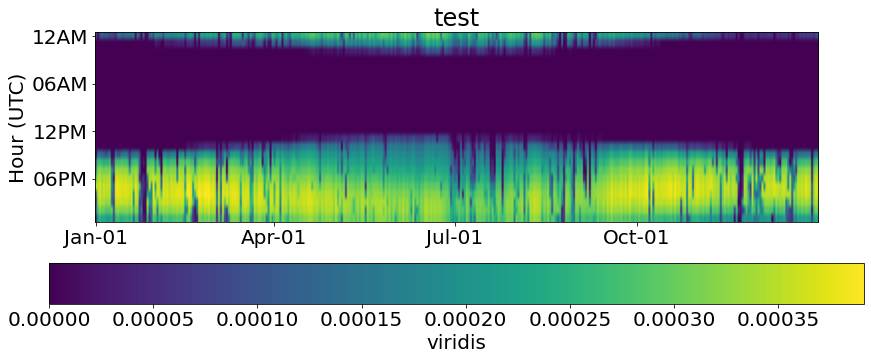

In [91]:
mpl.rcParams['font.size'] = 20

fig, ax = plt.subplots(figsize=(20, 5))

yearly_heatmap(solar_proportion_df.iloc[:,0].to_numpy(), 'test', 'viridis', 'viridis', ax=ax)

In [ ]:
# how about we try a two HUC8 model?

# pick, for example, 'San Francisco Bay' and 'Los Angeles'.

# vary the weights as described previously.

# plot: the number of data centers, and proportion of renewables used.

# plot: the number of HUC8 subbasins with some data center capacity, as a function of the weights alpha = gamma = delta.

# plot: a 365 * 24 table of grid, solar, and wind production.

# plot: a 365 * 24 table of data center usage.



# what if we fix: beta = 1, alpha = gamma = 0. and then vary delta from 0 to M. could we see how the distribution of data centers across the two locations transitions?

# here, if we get a list of outputs x_1 and x_2, we could plot x_1 against x_2.
# fig, ax = plt.subplots(figsize=(7, 5))
# ax.plot(deltas, x_1, color="C0", label="San Francisco Bay")
# ax.plot(deltas, x-2, color="C1", label="Los Angeles")

In [ ]:
# measuring complementarity:
# step 1 to see if there is any complementarity: perform the hypothesis test to see whether the correlation in output (1) between locations is negative. (2) between solar and wind is negative.

# step 2 to see if complementarity generalizes to unseen data: estimate the mean grid usage. (doesn't work if not enough renewables are built to sometimes exceed data center demand.) set the 95% confidence interval as the train year's mean, +/- two standard deviations.

# 2013: train year
g_2013_time = np.sum(g_2013, axis=0)

train_mean = np.mean(g_2013_time)
train_std = np.std(g_2013_time)
print(f"The confidence interval for the optimized 2013 data is ({train_mean - 2 * train_std:.2f}, {train_mean + 2 * train_std:.2f}) MWh.")

# 2011: test year
g_2011_time = np.sum(g_2011, axis=0)

test_mean = np.mean(g_2011_time)
print(f"The mean hourly grid usage for the 2011 data is {test_mean:.2f} MWh.")

Model-Specific Data: Derived Costs

Visualize Composite Costs: Grid, Solar, and Wind

In [ ]:
# functionalize

grid_parts_list = ['Grid WSF_1MWh_normalized', 'Electricity Price_normalized', 'Grid CF_1MWh_normalized']
solar_parts_list = ['Solar WSF_1MWh_normalized', 'Mean Solar LCOE_normalized', 'Solar CF_1MWh_normalized']
wind_parts_list = ['Wind WSF_1MWh_normalized', 'Mean Wind LCOE_normalized', 'Wind CF_1MWh_normalized']

def composite_costs(weights):
    """ 
    Calculates composite costs based on input weights.

    Parameters
    ----------
        weights: dict
            Dictionary of weights.

    Returns
    -------
        composite_costs_df: gpd.GeoDataFrame
            GeoDataframe with composite costs.
    """

    composite_costs_df = huc8_df.copy()

    # composite cost: grid electricity
    composite_costs_df['grid_composite_cost'] = np.sum([weights[part]*huc8_weights_default[part] for part in grid_parts_list], axis=0)

    composite_costs_df['solar_composite_cost'] = np.sum([weights[part]*huc8_weights_default[part] for part in solar_parts_list], axis=0)

    composite_costs_df['wind_composite_cost'] = np.sum([weights[part]*huc8_weights_default[part] for part in wind_parts_list], axis=0)

    return composite_costs_df

### Visualization of Results

In [ ]:
time_index = solar_proportion_df.index

def result_df(x, a, g, s, w): # consider whether we should combine this with the function above. - Richard
    """
    Stores optimized decision variables in a DataFrame for easy visualization.

    Parameters
    ----------
        x: Gurobi output
            Siting decisions of data centers
        a: Gurobi output
            Data center load allocation matrix
        g: Gurobi output
            Grid electricity usage matrix
        s: Gurobi output
            Annual solar usage
        w: Gurobi output
            Annual wind usage

    Returns
    -------
        huc8_decisions_df: gpd.GeoDataFrame
            GeoDataFrame with all of the decision variables
    """

    huc8_decisions_df = huc8_df.copy()

    huc8_decisions_df['Added Data Centers [MW]'] = x

    for idx, time in enumerate(time_index):
        huc8_decisions_df[f"Allocation {time}"] = a[:,idx]

        huc8_decisions_df[f"Grid {time}"] = g[:,idx]

    huc8_decisions_df[f"Total Allocation [MWh]"] = np.sum(a, axis=1)

    huc8_decisions_df[f"Total Grid Usage [MWh]"] = np.sum(g, axis=1)

    huc8_decisions_df['Annual Solar Usage [MWh]'] = s

    huc8_decisions_df['Annual Wind Usage [MWh]'] = w

    # get data center usage rates
    huc8_decisions_df['Divide Data Centers'] = huc8_decisions_df['Added Data Centers [MW]'].where(huc8_decisions_df['Added Data Centers [MW]'] > 0, 1)

    huc8_decisions_df['Data Center Capacity Factor'] = huc8_decisions_df['Total Allocation [MWh]']/(huc8_decisions_df['Divide Data Centers']*8760)

    return huc8_decisions_df

In [ ]:
# added data centers
visualize_stats(huc8_decisions_df, 'Added Data Centers [MW]', 'Added Data Center Capacity', 'Greens', 'MW')

In [ ]:
# data center capacity factor
visualize_stats(huc8_decisions_df, 'Data Center Capacity Factor', 'Data Center Capacity Factor', 'Greys', '') # unitless. We can also change to percentage if we want.

Pie Charts

In [ ]:
# pie chart: size is the total electricity consumption. sectors are how much electricity consumption comes from grid, solar, wind.

huc8_decisions_df['Total Grid Usage [MWh]']
huc8_decisions_df['Annual Solar Usage [MWh]']
huc8_decisions_df['Annual Wind Usage [MWh]']

usage_dict = {'Grid': 'Total Grid Usage [MWh]',
              'Solar': 'Total Solar Usage [MWh]', 
              'Wind': 'Total Wind Usage [MWh]'}

In [ ]:
# pie chart: size is the total water scarcity footprint. sectors are how much water scarcity footprint comes from grid, solar, wind, data center.

huc8_decisions_df['Total Grid Water Scarcity Footprint [m^3-eq]'] = huc8_decisions_df['Total Grid Usage [MWh]'] * huc8_decisions_df['Grid Water Scarcity Footprint [m3-eq/MWh]']
huc8_decisions_df['Total Solar Water Scarcity Footprint [m^3-eq]'] = huc8_decisions_df['Annual Solar Usage [MWh]'] * huc8_decisions_df['Solar Water Scarcity Footprint [m3-eq/MWh]']
huc8_decisions_df['Total Wind Water Scarcity Footprint [m^3-eq]'] = huc8_decisions_df['Annual Wind Usage [MWh]'] * huc8_decisions_df['Wind Water Scarcity Footprint [m3-eq/MWh]']
huc8_decisions_df['Total Data Center Water Scarcity Footprint [m^3-eq]'] = huc8_decisions_df['Total Allocation [MWh]'] * huc8_decisions_df['Data Center Water Scarcity Footprint [m3-eq/MWh]']

water_dict = {'Grid': 'Total Grid Water Scarcity Footprint [m^3-eq]',
              'Solar': 'Total Solar Water Scarcity Footprint [m^3-eq]',
              'Wind': 'Total Wind Water Scarcity Footprint [m^3-eq]',
              'Data Center': 'Total Data Center Water Scarcity Footprint [m^3-eq]'}

In [ ]:
# pie chart: size is the total emissions footprint. sectors are how much emissions footprint comes from grid, solar, and wind

huc8_decisions_df['Total Grid Emissions [tons CO2-eq]'] = huc8_decisions_df['Total Grid Usage [MWh]'] * huc8_decisions_df['Grid Carbon Footprint [tons CO2-eq/MWh]']
huc8_decisions_df['Total Solar Emissions [tons CO2-eq]'] = huc8_decisions_df['Annual Solar Usage [MWh]'] * huc8_decisions_df['Solar Carbon Footprint [tons CO2-eq/MWh]']
huc8_decisions_df['Total Wind Emissions [tons CO2-eq]'] = huc8_decisions_df['Annual Wind Usage [MWh]'] * huc8_decisions_df['Wind Carbon Footprint [tons CO2-eq/MWh]']

emissions_dict = {'Grid': 'Total Grid Emissions [tons CO2-eq]',
                  'Solar': 'Total Solar Emissions [tons CO2-eq]',
                  'Wind': 'Total Wind Emissions [tons CO2-eq]'}

In [ ]:
# pie chart: size is the total cost. sectors are how much cost comes from grid, solar, wind, and data center

huc8_decisions_df['Total Grid Cost [$]'] = huc8_decisions_df['Total Grid Usage [MWh]'] * huc8_decisions_df['Electricity Price [$/MWh]']
huc8_decisions_df['Total Solar Cost [$]'] = huc8_decisions_df['Annual Solar Usage [MWh]'] * huc8_decisions_df['Mean Solar LCOE [$/MWh]']
huc8_decisions_df['Total Wind Cost [$]'] = huc8_decisions_df['Annual Wind Usage [MWh]'] * huc8_decisions_df['Mean Wind LCOE [$/MWh]']
huc8_decisions_df['Total Data Center Cost [$]'] = huc8_decisions_df['Added Data Centers [MW]'] * data_center_cost

cost_dict = {'Grid': 'Total Grid Cost [$]',
             'Solar': 'Total Solar Cost [$]',
             'Wind': 'Total Wind Cost [$]',
             'Data Center': 'Total Data Center Cost [$]'}

In [ ]:
# pick colors

color_dict = {
    'Grid': 'silver',
    'Solar': 'yellow',
    'Wind': 'blue',
    'Data Center': 'red'
}

In [ ]:
# if this gets too complicated, place it into a class structure.

# other resources: https://www.geeksforgeeks.org/python/how-to-set-border-for-wedges-in-matplotlib-pie-chart/

def geoplot_pie(df, lat_col, lon_col, category_dict, unit_factor, unit, pie_scale, ax=None):
    """ 
    Plot a map, with pie charts at the centroid of each region. Area of pie chart is proportional to the total amount.

    Parameters
    ----------
        df: gpd.GeoDataFrame
            GeoDataFrame with data of interest.
        lat_col: string
            Name of column with latitude coordinates.
        lon_col: string
            Name of column with longitude coordinates.
        category_dict: dictionary
            Dictionary with sources (grid, solar, wind, data center) as keys, and column names as values.
        unit_factor: float
            Conversion factor from measurements to unit of measurement.
        unit: string
            Unit of measurement.
        pie_scale: float
            Scaling factor for pie size.
        ax: matplotlib.axes.Axes
            Axes to plot the map and pie chart on.

    Returns
    -------
        None
    """

    if ax is None:
        ax = plt.gca() # get current axis
    

    # plot the pie charts
    for _, row in df.iterrows():
        lat, lon = transformer_inv.transform(row[lat_col], row[lon_col])
        ax.pie(row[category_dict.values()], labels=category_dict.keys(), radius=np.sqrt(row[category_dict.values()].sum()) * pie_scale, \
               center=(lon, lat), colors=color_dict[category_dict.keys()], wedgeprops={
                   'edgecolor': 'black',
                   'linewidth': 2
               })
        
    # make the pie size legend
    ref_sizes = np.linspace(0, df[category_dict.values()].sum().max(), 4)[1:] # get three reference sizes

    for size in ref_sizes:
        ref_label = f'{size * unit_factor:.1f}' + unit
        ax.pie(size, radius=size * pie_scale, color='white', zorder=-3, label=ref_label, wedgeprops={
            'edgecolor': 'black',
            'linewidth': 2
        }) # TODO might need to modify this later on

    # make the color legend
    for key in category_dict.keys():
        ax.bar(0, 0, color=color_dict[key], label=key, zorder=-3)

    ax.legend()

Bar Charts

In [ ]:
def stack_bar(df_dict, category_dict, x_label, y_label, title, ax=None):
    """ 
    Plots stacked bars to show total accumulated values.

    Parameters
    ----------
        df_dict: dictionary of gpd.GeoDataFrame
            GeoDataFrames with aggregated total data for plotting.
        category_dict: dictionary
            Dictionary with sources (grid, solar, wind, data center) as keys, and column names as values.
        x_label: string
            X-axis label.
        y_label: string
            Y-axis label.
        title: string
            Title of plot.
        ax: matplotlib.axes.Axes
            Axes to plot stacked bars on.

    Returns
    -------
        None
    """

    # TODO this function does too many steps at once, break it down?

    if ax is None:
        ax = plt.gca()

    # plot the bars for total data
    for idx, scenario_df in enumerate(df_dict.values()):
        bottom = 0

        for source in category_dict.keys():
            source_sum = scenario_df[category_dict[source]].sum() # sum over all HUC8 subbasins
        
            ax.bar(idx, source_sum, color=color_dict[source], bottom=bottom)
            bottom += source_sum

    # labeling
    ax.set_xlabel(x_label)
    ax.set_xticks(np.arange(len(df_dict.keys())), category_dict.keys()) # set x ticks indicating scenarios

    ax.set_ylabel(y_label)
    ax.set_title(title)

    # hidden legend elements
    for source in category_dict.keys():
        ax.bar(0, 1, color=color_dict[source], label=source, zorder=-3)

    ax.legend()

Cumulative Curve

In [ ]:
def cumulative_curve(df, data_col, x_label, y_label, ax=None):
    """ 
    Plots cumulative distribution curve for mean absolute difference, similar to a Lorenz curve for Gini coefficient (https://en.wikipedia.org/wiki/Gini_coefficient), except it is not scaled down to fit between 0 and 1.

    Parameters
    ----------
        df: pd.DataFrame
            DataFrame with input data
        data_col: string
            Column of DataFrame with data of interest
        x_label: string
            X-axis label
        y_label: string
            Y-axis label
        ax: matplotlib.axes.Axes
            Axis to plot cumulative distribution curve on

    Returns
    -------
        None
    """

    # sort DataFrame by values of interest
    df.sort_values(by=data_col, ascending=True, inplace=True)

    # get cumulative sum
    cumulative_sum_data = np.cumsum(df[data_col])

    # red reference line
    ax.plot([0, len(df)], [0, df[data_col].sum()], label="Line of Equality", color="red")

    # blue cumulative distribution curve
    ax.plot(np.arange(len(df)+1), np.concat([np.array(0), cumulative_sum_data], axis=0), label="Cumulative Distribution Curve", color="blue")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.legend()

In [ ]:
# TODO unsure if we will need this version after all
def lorenz_curve(df, data_col, x_label, y_label, ax=None):
    """ 
    Plots Lorenz curve (https://en.wikipedia.org/wiki/Gini_coefficient). Uses regular version, which is contained between 0 and 1.

    Parameters
    ----------
        df: pd.DataFrame
            DataFrame with input data
        data_col: string
            Column of DataFrame with data of interest
        x_label: string
            X-axis label
        y_label: string
            Y-axis label
        ax: matplotlib.axes.Axes
            Axis to plot Lorenz curve on

    Returns
    -------
        None
    """

    # sort DataFrame by values of interest
    df.sort_values(by=data_col, ascending=True, inplace=True)

    # get cumulative sum (scaled down by the max value)
    cumulative_sum_data = np.cumsum(df[data_col])/df[data_col].max()

    # red reference line
    ax.plot([0, len(df)], [0, 1], label="Line of Equality", color="red")

    # blue Lorenz curve
    ax.plot(np.arange(len(df)+1), np.concat([np.array(0), cumulative_sum_data], axis=0), label="Lorenz Curve", color="blue")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.legend()

Complementarity

In [ ]:
# solar production by time step. TODO should we also put this in result_df?
solar_usage_hourly = solar_proportion_df.values.sum(axis=1)*s

# wind production by time step. 
wind_usage_hourly = wind_proportion_df.values.sum(axis=1)*w

2013 Plots

In [ ]:
# plot solar, wind, and total demand as time series

DEMAND = # TODO (flat_demand_2GWh, business_demand_2GWh, or caiso_2013_2GWh)

time_range = pd.date_range('2013-01-01', '2013-12-31', freq='h')

fig, ax = plt.subplots(figsize=(18, 6))

# plot solar
ax.plot(time_range, solar_usage_hourly, color='C1', linewidth=2, label="Solar") # alternatively, we can try yellow color for solar

# plot wind
ax.plot(time_range, wind_usage_hourly, color='C0', linewidth=2, label="Wind") # alternatively, we can try blue color for wind

# plot aggregate
ax.plot(time_range, solar_usage_hourly+wind_usage_hourly, color="C2", linewidth=4, label="Total Renewables")

# plot data center demand
ax.plot(time_range, DEMAND, color='black', label="Data Center Load")

In [ ]:
def print_correlation(data_1, data_2, data_1_name, data_2_name):
    """ 
    Prints the correlation, and p-value from testing whether the correlation is significantly different from 0, 
    between data_1 and data_2.

    Parameters
    ----------
        data_1: np.ndarray
            Numpy array with first set of data.
        data_2: np.ndarray
            Numpy array with second set of data.
        data_1_name: np.ndarray
            Name of first set of data.
        data_2_name: np.ndarray
            Name of second set of data.

    Returns
    -------
        slope: float
            Slope of the line of best fit
        intercept: float
            Intercept of the line of best fit
    """

    slope, intercept, rvalue, pvalue, _ = stats.linregress(data_1, data_2)

    print(f"The slope for the line of best fit between {data_1_name} and {data_2_name} is {slope}. \
          \nThe R^2 correlation between {data_1_name} and {data_2_name} is {rvalue**2:.3f}. \
          \nThe p-value from testing whether the slope is 0 is {pvalue:.3f}.")

    return slope, intercept

In [ ]:
def plot_correlation(data_1, data_2, slope, intercept, x_label, y_label, title, buffer=buffer, ax=None):
    """ 
    Makes a scatterplot of the datasets, along with line of best fit.

    Parameters
    ----------
        data_1: np.ndarray
            First set of data.
        data_2: np.ndarray
            Second set of data.
        slope: float
            Slope of the line of best fit.
        intercept: float
            Intercept of the line of best fit.
        x_label: string
            X-axis label.
        y_label: string
            Y-axis label.
        title: string
            Title for the plot.
        buffer: float
            Determines limits (np.max(data) * buffer) for the edge of the line of best fit.
        ax: matplotlib.axes.Axes
            Axes to make the plot on.

    Returns
    -------
        None
    """

    if ax is None:
        ax = plt.gca()

    ax.scatter(data_1, data_2) # TODO consider whether scatterpoint size will need to be adjusted.

    ax.plot(np.linspace(0, np.max(data_1)*buffer), slope*np.linspace(0, np.max(data_1)*buffer) + intercept, color="red", linewidth=4, label=rf"{slope:3f}x + {intercept:.0f}")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.legend()

In [ ]:
# calculate correlation between solar and wind
slope, intercept = print_correlation(solar_usage_hourly, wind_usage_hourly)

# slope, intercept, rvalue, pvalue, _ = stats.linregress(solar_usage_hourly, wind_usage_hourly)

# print(f"The R^2 correlation between solar and wind production is {rvalue**2:.3f}. The p-value from testing whether the slope is 0 is {pvalue:.3f}.")

In [ ]:
# plot complementarity between solar and wind

fig, ax = plt.subplots(figsize=(9,9))

plot_correlation(solar_usage_hourly, wind_usage_hourly, slope, intercept, "Solar Electricity Usage [MWh]", "Wind Electricity Usage [MWh]", "Linear Regression of Solar and Wind Electricity Production", ax=ax)

# ax.scatter(solar_usage_hourly, wind_usage_hourly) # might need to tune the scatterpoint size later on
# ax.plot(np.linspace(0, np.max(solar_usage_hourly)*1.1), slope*np.linspace(0, np.max(solar_usage_hourly)*1.1)+intercept, color="red", linewidth=4, label=rf"{slope:.3f}x + {intercept:.0f}")

# ax.set_xlabel("Solar Electricity Usage [MWh]")
# ax.set_ylabel("Wind Electricity Usage [MWh]")
# ax.set_title("Linear Regression of Solar and Wind Electricity Production")
# ax.legend()

In [ ]:
# tradeoff of emissions and water scarcity footprint

# tradeoff_np = # TODO

# slope, intercept, _, _, _ = stats.linregress(tradeoff_np[:,0], tradeoff_np[:,1])

slope, intercept = print_correlation(tradeoff_np[:,0], tradeoff_np[:,1])

In [ ]:
# plot the tradeoff pairs of emissions and water scarcity footprint

fig, ax = plt.subplots(figsize=(7,7))

plot_correlation(tradeoff_np[:,0], tradeoff_np[:,1], slope, intercept, "Average Water Scarcity \n" + r"Footprint [m$^3$-eq/MWh]", "Average Emissions\n" + r"Footprint [tons CO$_{2}$-eq/MWh]", "Tradeoff of Water Scarcity and Emissions", ax=ax)

# ax.scatter(tradeoff_np[:,0], tradeoff_np[:,1])

# ax.set_xlabel("Average Water Scarcity \n" + r"Footprint [m$^3$-eq/MWh]")
# ax.set_ylabel("Average Emissions\n" + r"Footprint [tons CO$_2$-eq/MWh]")

# ax.set_title("Tradeoff of Water Scarcity and Emissions")

# ax.plot(np.linspace(0, np.max(tradeoff_np[:,0]) * 1.1), slope*np.linspace(0, np.max(tradeoff_np[:,0]) * 1.1) + intercept, color='black', linewidth=2, label=f"{slope:.4f}x + {intercept:.2f}")

# ax.legend()